<a href="https://www.kaggle.com/code/ludmiladias/multiclasses-unet?scriptVersionId=140709878" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div id="title"><h1 style="color:white;background:#62909d;border-radius:5px;padding:30px;font-family:'Sans-Serif', cursive;font-size:50px;text-align:center">U-Net Multiclasses Training</h1></div>

Projeto desenvolvido usando a rede de segmentação U-NET, biblioteca Keras e Tensorflow.
O Road Mapper DNN tem como objetivo gerar mapas de estrada com segmentação das faixas de sinalização utilizada pelos veículos, tendo como entrada mapas de remissão gerados pelo LIDAR - sensor laser que faz parte do sistema de carros autônomos como o ASTRO da Lume Robotics.


Input | Output
------|--------
![](https://github.com/LCAD-UFES/carmen_lcad/blob/master/src/road_mapper/data/i7705600_-338380.png?raw=true)|![](https://github.com/LCAD-UFES/carmen_lcad/blob/master/src/road_mapper/data/r7705600_-338380_map_1_6.png?raw=true)



## <div id="summary">**<font color="#62909d" size="5">Tabela de Conteúdos</font>**</div>

**<font size="2"><a href="#chap1">1. Instalar Pacotes</a></font>**
**<br><font size="2"><a href="#chap2">2. Configurações Iniciais</a></font>**
**<br><font size="2"><a href="#chap3">3. Tratamento de Dados</a></font>**
**<br><font size="2"><a href="#chap4">4. Compilação e Treinamento da Rede</a></font>**
**<br><font size="2"><a href="#chap5">5. Analisando os Resultados</a></font>**
**<br><font size="2"><a href="#chap6">6. Realizando Testes</a></font>**

<div id="chap1"><h1 style="color:white;background:#62909d;border-radius:5px;padding:30px;font-family:'Sans-Serif', cursive;font-size:50px;text-align:center">Instalar Pacotes</h1></div>


In [2]:
%pip install opencv-python
%pip install tensorflow
%pip install numpy
%pip install tqdm
%pip install scikit-image
%pip install scikit-learn
%pip install matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 15.2 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 29.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.9/220.9 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

<div id="chap2"><h1 style="color:white;background:#62909d;border-radius:5px;padding:30px;font-family:'Sans-Serif', cursive;font-size:30px;text-align:center">Configurações Iniciais</h1></div>


In [8]:
import os
import glob

import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from skimage.io import imread, imshow
from skimage.transform import resize

In [9]:
SIZE_X = 128 
SIZE_Y = 128

TRAIN_PATH = 'DATASET/treino/'
TEST_PATH_HIGHWAY = 'DATASET/teste/highway/'
TEST_PATH_UFES = 'DATASET/teste/ufes/'

IMG_CHANNELS = 1
NUM_CLASSES = 17  # Número de classes

<div id="chap3"><h1 style="color:white;background:#62909d;border-radius:5px;padding:30px;font-family:'Sans-Serif', cursive;font-size:50px;text-align:center">Tratamento de Dados</h1></div>

Pule essa etapa se você já tiver seus dados prontos em um JSON.

**<font color="#62909d" size="5">Importando os arquivos</font>**


In [3]:
# Obter uma lista das subpastas
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids_hw = next(os.walk(TEST_PATH_HIGHWAY))[1]
test_ids_uf = next(os.walk(TEST_PATH_UFES))[1]

StopIteration: 

In [ ]:
X_train = np.zeros((len(train_ids), SIZE_Y, SIZE_X, IMG_CHANNELS), dtype = np.uint8)
Y_train = np.zeros((len(train_ids), SIZE_Y, SIZE_X), dtype = np.uint8)


X_test1 = np.zeros((len(test_ids_hw), SIZE_Y, SIZE_X, IMG_CHANNELS), dtype=np.uint8)
Y_test1= np.zeros((len(test_ids_hw), SIZE_Y, SIZE_X, 1), dtype = np.uint8)


X_test2 = np.zeros((len(test_ids_uf), SIZE_Y, SIZE_X, IMG_CHANNELS), dtype=np.uint8)
Y_test2= np.zeros((len(test_ids_uf), SIZE_Y, SIZE_X, 1), dtype = np.uint8)

In [ ]:
# CARREGA IMAGENS PARA ARRAY DE TREINO

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):  
    
    path = TRAIN_PATH + id_  
    img = imread(path + '/images/i' + id_ + '.png', 0)[:, :, :IMG_CHANNELS]  
    img = resize(img, (SIZE_Y, SIZE_X), mode='constant', preserve_range=True)  
    X_train[n] = img 
    mask = np.zeros((SIZE_Y, SIZE_X, 1), dtype = np.uint8)  
    
    for mask_file in next(os.walk(path + '/masks/'))[2]:  
        mask_ = imread(path + '/masks/' + mask_file, 0)
        mask = resize(mask_, (SIZE_Y, SIZE_X), mode='constant', preserve_range=True)
        
    Y_train[n] = mask
Y_train = np.expand_dims(Y_train, axis = 3)    

In [ ]:
# SALVAR ARRAYS DAS IMAGENS

import pickle
try:  
    arquivo = open("bin/treinoX.bin", "wb")
    pickle.dump(X_train, arquivo)
    arquivo.close()
except:
    print("Problemas com o arquivo treino.")
    
try:  
    arquivo = open("bin/treinoY.bin", "wb")
    pickle.dump(Y_train, arquivo)
    arquivo.close()
except:
    print("Problemas com o arquivo teste.")

In [5]:
#  LOAD DOS ARRAYS SALVOS

import pickle

try:
    arquivo = open("/kaggle/input/road-mapper-dataset/treinoX.bin", "rb")
    X_train = pickle.load(arquivo)
    arquivo.close()
except:
    print("Problemas com o arquivo treinox.")
    
try:
    arquivo = open("/kaggle/input/road-mapper-dataset/treinoY.bin", "rb")
    Y_train = pickle.load(arquivo)
    arquivo.close()
except:
    print("Problemas com o arquivo treinoy.")

In [6]:
image_dataset = X_train
mask_dataset = Y_train

**<font color="#62909d" size="5">Normalização e tratamento dos arrays</font>**


In [7]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (15000, 128, 128, 1)
Mask data shape is:  (15000, 128, 128, 1)
Max pixel value in image is:  254
Labels in the mask are :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [8]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = mask_dataset.shape  
mask_dataset_reshaped = mask_dataset.reshape(-1,1)
mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)

np.unique(mask_dataset_encoded)

ValueError: too many values to unpack (expected 3)

In [ ]:
mask_dataset_encoded = np.expand_dims(mask_dataset_encoded, axis = 3)
print(mask_dataset_encoded.shape)

In [9]:
#Normalizar images
image_dataset = image_dataset /255.  #Can also normalize or scale using MinMax scaler

In [10]:
#Dividir dados de treino e teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.2, random_state = 42)

In [1]:
# SALVAR ARRAYS DAS IMAGENS

import pickle
try:  
    arquivo = open("bin/testeX_.bin", "wb")
    pickle.dump(X_test, arquivo)
    arquivo.close()
except:
    print("Problemas com o arquivo treino.")
    
# try:  
#     arquivo = open("bin/testeY_.bin", "wb")
#     pickle.dump(y_test, arquivo)
#     arquivo.close()
# except:
#     print("Problemas com o arquivo teste.")
    
try:  
    arquivo = open("bin/treinoX_.bin", "wb")
    pickle.dump(X_train, arquivo)
    arquivo.close()
except:
    print("Problemas com o arquivo treino.")
    
# try:  
#     arquivo = open("bin/treinoY_.bin", "wb")
#     pickle.dump(y_train, arquivo)
#     arquivo.close()
# except:
#     print("Problemas com o arquivo teste.")

Problemas com o arquivo treino.
Problemas com o arquivo treino.


In [2]:
#  LOAD DOS ARRAYS SALVOS

import pickle

try:
    arquivo = open("/kaggle/input/road-mapper-dataset/testeX_.bin", "rb")
    X_test = pickle.load(arquivo)
    arquivo.close()
except:
    print("Problemas com o arquivo treinox.")
    
# try:
#     arquivo = open("/kaggle/input/road-mapper-dataset/testeY_.bin", "rb")
#     y_test = pickle.load(arquivo)
#     arquivo.close()
# except:
#     print("Problemas com o arquivo treinoy.")
try:
    arquivo = open("/kaggle/input/road-mapper-dataset/treinoX_.bin", "rb")
    X_train = pickle.load(arquivo)
    arquivo.close()
except:
    print("Problemas com o arquivo treinox.")
    
# try:
#     arquivo = open("/kaggle/input/road-mapper-dataset/treinoY_.bin", "rb")
#     y_train = pickle.load(arquivo)
#     arquivo.close()
# except:
#     print("Problemas com o arquivo treinoy.")

In [9]:
from tensorflow.keras.utils import to_categorical

train_masks_cat = to_categorical(y_train, num_classes=NUM_CLASSES)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], NUM_CLASSES))

test_masks_cat = to_categorical(y_test, num_classes=NUM_CLASSES)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], NUM_CLASSES))


In [ ]:
# SALVAR ARRAYS DAS IMAGENS

import pickle
try:  
    arquivo = open("y_train_cat.bin", "wb")
    pickle.dump(y_train_cat, arquivo)
    arquivo.close()
except:
    print("Problemas com o arquivo treino.")

try:  
    arquivo = open("y_test_cat.bin", "wb")
    pickle.dump(y_test_cat, arquivo)
    arquivo.close()
except:
    print("Problemas com o arquivo teste.")
    


In [3]:
import pickle

try:
    arquivo = open("/kaggle/input/road-mapper-dataset/y_train_cat.bin", "rb")
    y_train_cat = pickle.load(arquivo)
    arquivo.close()
except:
    print("Problemas com o arquivo treinox.")
    
try:
    arquivo = open("/kaggle/input/road-mapper-dataset/y_test_cat.bin", "rb")
    y_test_cat = pickle.load(arquivo)
    arquivo.close()
except:
    print("Problemas com o arquivo treinoy.")

In [ ]:
print(y_train_cat.shape)
print(y_test_cat.shape)

In [7]:
# SALVAR COMO ARQUIVO CSV (verificar tempo de execução...)

import csv
import pandas as pd

# Criar um DataFrame com os arrays
data = {'X input': X_train.tolist(), 'Y output': y_train_cat.tolist()}
df = pd.DataFrame(data)
df.to_csv('train_data.csv', index=False)

Note: you may need to restart the kernel to use updated packages.


<div id="chap4"><h1 style="color:white;background:#62909d;border-radius:5px;padding:30px;font-family:'Sans-Serif', cursive;font-size:40px;text-align:center">Compilação e Treinamento da Rede</h1></div>

**<font color="#62909d" size="5">Modelo 1 - Original U-NET</font>**

In [1]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [5]:
# Construindo a UNET dividindo em blocos enconder e decoder

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

# Bloco Encoder: Bloco Conv seguindo por maxpooling

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

# Bloco Decoder
# Pula features recebe de entrada os dados direto do encoder para a concatenação

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x
# Construção da UNET
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(NUM_CLASSES, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [6]:
# Criando uma função para um convolution block
def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu", 
                               kernel_initializer="he_normal", padding="same")(inputs)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu", 
                               kernel_initializer="he_normal", padding="same")(x)
    return x

# Criando a função para o expanding path
def upsample_block(inputs, conv_prev, num_filters):
    up = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding="same")(inputs)
    concat = tf.keras.layers.concatenate([up, conv_prev])
    conv = conv_block(concat, num_filters)
    return conv


In [10]:
import tensorflow as tf

# Inputs
inputs = tf.keras.layers.Input((SIZE_X, SIZE_Y, IMG_CHANNELS))

# Normalização
s = tf.keras.layers.Lambda(lambda x: x/255.0)(inputs) 

# Contraction path
c1 = conv_block(s, 16)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = conv_block(p1, 32)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = conv_block(p2, 64)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = conv_block(p3, 128)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

c5 = conv_block(p4, 256)

# Expansive path
c6 = upsample_block(c5, c4, 128)
c7 = upsample_block(c6, c3, 64)
c8 = upsample_block(c7, c2, 32)
c9 = upsample_block(c8, c1, 16)

# Output layer

outputs = tf.keras.layers.Conv2D(NUM_CLASSES, (1, 1), activation='softmax')(c9)

In [11]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs], name="U-Net")

# Compilação
opt = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              


**<font color="#62909d" size="5">Modelo 2 - Squeeze U-NET</font>**

In [4]:

from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout
from keras.layers import concatenate, Conv2DTranspose, BatchNormalization
from keras import backend as K



def fire_module(x, fire_id, squeeze=16, expand=64):
    f_name = "fire{0}/{1}"
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    x = Conv2D(squeeze, (1, 1), activation='relu', padding='same', name=f_name.format(fire_id, "squeeze1x1"))(x)
    x = BatchNormalization(axis=channel_axis)(x)

    left = Conv2D(expand, (1, 1), activation='relu', padding='same', name=f_name.format(fire_id, "expand1x1"))(x)
    right = Conv2D(expand, (3, 3), activation='relu', padding='same', name=f_name.format(fire_id, "expand3x3"))(x)
    x = concatenate([left, right], axis=channel_axis, name=f_name.format(fire_id, "concat"))
    return x


def SqueezeUNet(inputs, num_classes=None, deconv_ksize=3, dropout=0.5, activation='sigmoid'):
    """SqueezeUNet is a implementation based in SqueezeNetv1.1 and unet for semantic segmentation
    :param inputs: input layer.
    :param num_classes: number of classes.
    :param deconv_ksize: (width and height) or integer of the 2D deconvolution window.
    :param dropout: dropout rate
    :param activation: type of activation at the top layer.
    :returns: SqueezeUNet model
    """
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    if num_classes is None:
        num_classes = K.int_shape(inputs)[channel_axis]

    x01 = Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu', name='conv1')(inputs)
    x02 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1', padding='same')(x01)

    x03 = fire_module(x02, fire_id=2, squeeze=16, expand=64)
    x04 = fire_module(x03, fire_id=3, squeeze=16, expand=64)
    x05 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3', padding="same")(x04)

    x06 = fire_module(x05, fire_id=4, squeeze=32, expand=128)
    x07 = fire_module(x06, fire_id=5, squeeze=32, expand=128)
    x08 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5', padding="same")(x07)

    x09 = fire_module(x08, fire_id=6, squeeze=48, expand=192)
    x10 = fire_module(x09, fire_id=7, squeeze=48, expand=192)
    x11 = fire_module(x10, fire_id=8, squeeze=64, expand=256)
    x12 = fire_module(x11, fire_id=9, squeeze=64, expand=256)

    if dropout != 0.0:
        x12 = Dropout(dropout)(x12)

    up1 = concatenate([
        Conv2DTranspose(192, deconv_ksize, strides=(1, 1), padding='same')(x12),
        x10,
    ], axis=channel_axis)
    up1 = fire_module(up1, fire_id=10, squeeze=48, expand=192)

    up2 = concatenate([
        Conv2DTranspose(128, deconv_ksize, strides=(1, 1), padding='same')(up1),
        x08,
    ], axis=channel_axis)
    up2 = fire_module(up2, fire_id=11, squeeze=32, expand=128)

    up3 = concatenate([
        Conv2DTranspose(64, deconv_ksize, strides=(2, 2), padding='same')(up2),
        x05,
    ], axis=channel_axis)
    up3 = fire_module(up3, fire_id=12, squeeze=16, expand=64)

    up4 = concatenate([
        Conv2DTranspose(32, deconv_ksize, strides=(2, 2), padding='same')(up3),
        x02,
    ], axis=channel_axis)
    up4 = fire_module(up4, fire_id=13, squeeze=16, expand=32)
    up4 = UpSampling2D(size=(2, 2))(up4)

    x = concatenate([up4, x01], axis=channel_axis)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(num_classes, (1, 1), activation=activation)(x)

    return Model(inputs=inputs, outputs=x)
   

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [5]:
import tensorflow as tf
from keras.layers import Input

inputs = Input((SIZE_X, SIZE_Y, IMG_CHANNELS))
model = SqueezeUNet(inputs, num_classes=NUM_CLASSES, deconv_ksize=3)

opt = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 64, 64, 64)   640         ['input_1[0][0]']                
                                                                                                  
 pool1 (MaxPooling2D)           (None, 32, 32, 64)   0           ['conv1[0][0]']                  
                                                                                                  
 fire2/squeeze1x1 (Conv2D)      (None, 32, 32, 16)   1040        ['pool1[0][0]']              

**<font color="#62909d" size="5">Batch Generator</font>**

In [15]:
from tensorflow.keras.utils import to_categorical
import json

def batch_generator(Train_df,batch_size,
                    steps):
    idx=1
    while True: 
        yield load_data(Train_df,idx-1,batch_size)## Yields data
        if idx<=steps:
            idx+=1
        else:
            idx=1
            
def load_data(Train_df,idx,
              batch_size):
    n_classes = 17

    df = pd.read_csv(
                  Train_df, skiprows=idx*batch_size,
                  nrows=batch_size)
    
    x = [] 
    y = []
    
    for i in range(0, batch_size):
        x.append(json.loads(df.iloc[i,0]))
        y.append(json.loads(df.iloc[i,1]))
    
    y = np.asarray(y)
    train_masks_cat = to_categorical(y, num_classes=n_classes)
    y_train_cat = train_masks_cat.reshape((y.shape[0], y.shape[1], y.shape[2], n_classes))
    
    return (np.asarray(x), y_train_cat)

In [18]:
import numpy as np

from keras.models import Sequential 
from keras.layers import Dense, Activation
batch_size = 8 
nb_epoch = 3

# Objetos gerados para treino e validação
steps_per_epoch=np.ceil(2000/batch_size)
validation_steps=np.ceil(400/batch_size)

my_training_batch_generator = batch_generator('/kaggle/input/road-mapper-dataset-csv/train_data.csv', batch_size,steps_per_epoch)
my_validation_batch_generator = batch_generator('/kaggle/input/road-mapper-dataset-csv/test_data.csv', batch_size,validation_steps)


In [19]:


import pandas as pd

history = model.fit(my_training_batch_generator,
                    epochs=nb_epoch,
                    steps_per_epoch=steps_per_epoch,
                    verbose=1, 
                    validation_data=my_validation_batch_generator,
                    validation_steps=validation_steps,
                    shuffle=True,
                    use_multiprocessing=True)


Epoch 1/3
250/250 [==============================] - 963s 4s/step - loss: 725664640.0000 - categorical_accuracy: 0.3661 - val_loss: 1442391168.0000 - val_categorical_accuracy: 0.6625
Epoch 2/3
250/250 [==============================] - 966s 4s/step - loss: 4998747136.0000 - categorical_accuracy: 0.4392 - val_loss: 5240921600.0000 - val_categorical_accuracy: 0.6871
Epoch 3/3
250/250 [==============================] - 904s 4s/step - loss: 4287285248.0000 - categorical_accuracy: 0.4555 - val_loss: 5527619072.0000 - val_categorical_accuracy: 0.6891


In [ ]:
# Salvando o modelo
model.save('multiclass_road_mapper')


In [22]:
# Salvando os resultados
import pickle
try:  
    arquivo = open("results.bin", "wb")
    pickle.dump(history, arquivo)
    arquivo.close()
except:
    print("Problemas com o arquivo results.")
   

In [21]:
# Salvando os resultados
import pickle
try:  
    arquivo = open("results.json", "w")
    json.dump(history, arquivo, indent=4)
    arquivo.close()
except:
    print("Problemas com o arquivo results json.")
   

Problemas com o arquivo results json.


In [ ]:
import os
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

In [ ]:
download_file('/kaggle/working', 'out')

<div id="chap5"><h1 style="color:white;background:#62909d;border-radius:5px;padding:30px;font-family:'Sans-Serif', cursive;font-size:40px;text-align:center">Analisando os Resultados</h1></div>

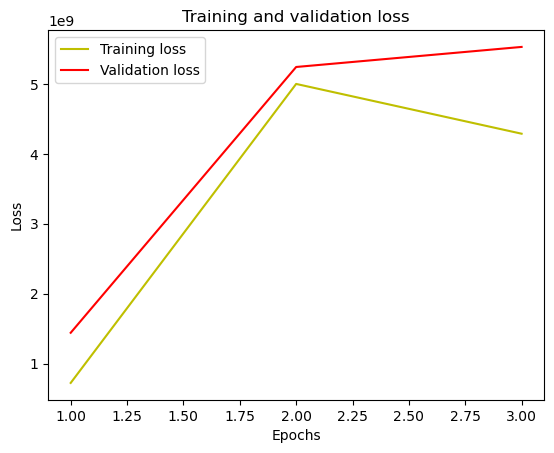

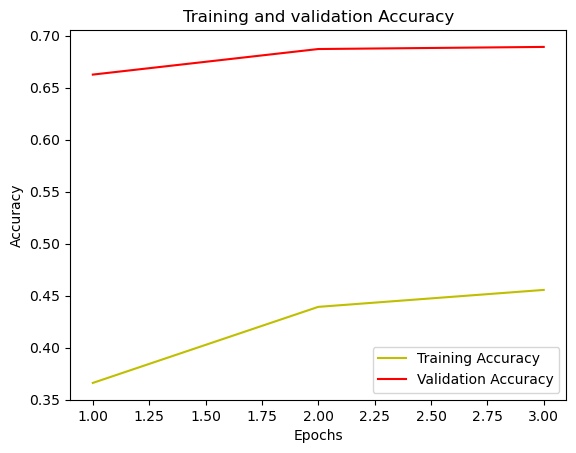

In [25]:

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Load do modelo salvo
from keras.models import load_model
model = load_model("/content/drive/MyDrive/Colab Notebooks/saved_models/tutorial119_sandstone_50epochs.hdf5", compile=False)

<div id="chap6"><h1 style="color:white;background:#62909d;border-radius:5px;padding:30px;font-family:'Sans-Serif', cursive;font-size:40px;text-align:center">Realizando testes (Predict)</h1></div>

In [ ]:
y_pred=model.predict(X_test)

In [ ]:
y_pred.shape

In [ ]:
y_pred_argmax=np.argmax(y_pred, axis=3)
y_pred_argmax.shape

In [ ]:
#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

In [ ]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)



In [ ]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
import random
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()